# Coal mining disaster

This is similar to https://docs.pymc.io/projects/examples/en/latest/BART/BART_introduction.html

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc_bart as pmb

In [2]:
RANDOM_SEED = 4579
np.random.seed(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
coal = np.loadtxt("coal.csv")

In [4]:
# discretize data
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist


In [5]:
with pm.Model() as model_coal:
    μ_ = pmb.BART("μ_", X=x_data, Y=np.log(y_data), m=20)
    μ = pm.Deterministic("μ", np.exp(μ_))
    y_pred = pm.Poisson("y_pred", mu=μ, observed=y_data)
    idata_coal = pm.sample(random_seed=RANDOM_SEED,
                           compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


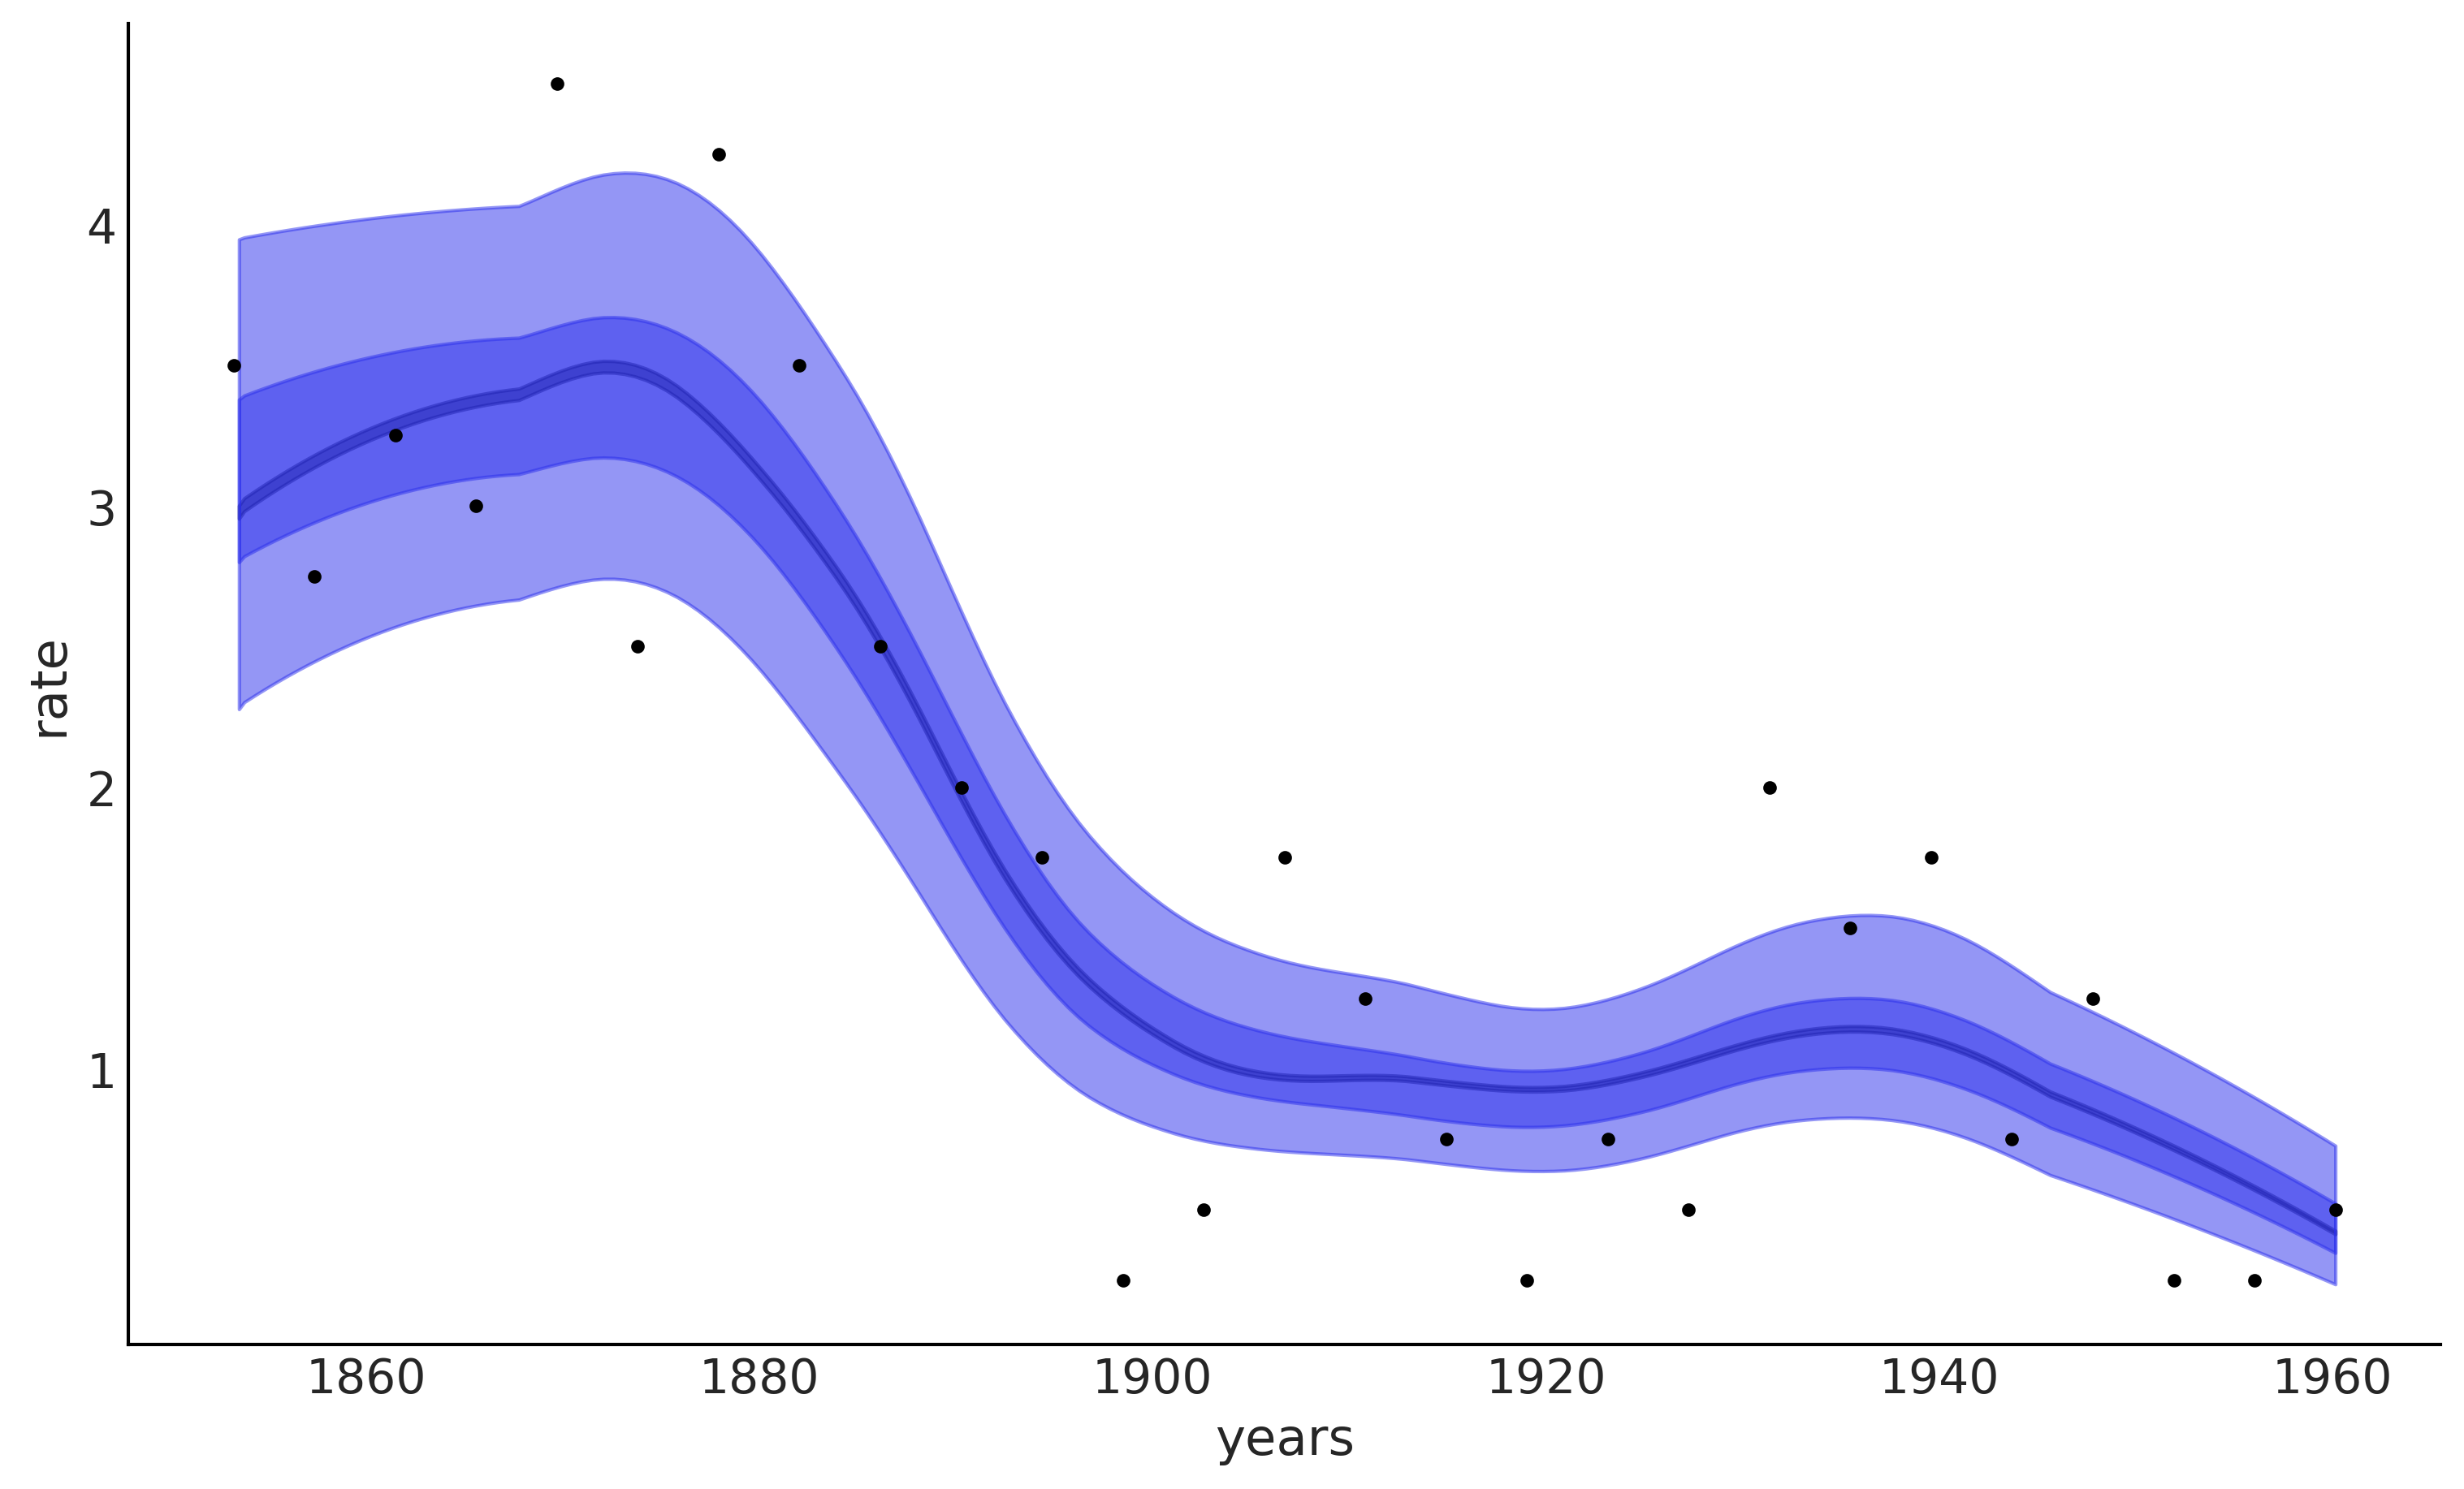

In [6]:
_, ax = plt.subplots(figsize=(10, 6))

rates = idata_coal.posterior["μ"] / 4
rate_mean = idata_coal.posterior["μ"].mean(dim=["draw", "chain"]) / 4
ax.plot(x_centers, y_data/4, "k.")
az.plot_hdi(x_centers, rates, smooth=True, color="k", hdi_prob=0.05)

az.plot_hdi(x_centers, rates, smooth=True, color="C0")
az.plot_hdi(
    x_centers, rates, hdi_prob=0.5, smooth=True, color="C0", plot_kwargs={"alpha": 0}
)
#ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate")
plt.savefig("coal_mining.png");